# Importações

In [326]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Leitura dataset e pré-processamento

In [314]:
global dataset
global dataset_original

def load_dataset():
    global dataset
    global dataset_original
    
    dataset = pd.read_csv('coverage-dataset.csv', sep=';')
    dataset_original = dataset
    
def under_sampling():
    global dataset
    
    rus = RandomUnderSampler(random_state=0, sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(
            pd.DataFrame(dataset.index.array)[0].values.reshape(-1,1), 
            dataset['Cyclomatic'].values
    )

    dataset = dataset.iloc[X_res.reshape(1,-1)[0]]
    
def remove_last_column():
    global dataset
    
    dataset = dataset.iloc[:,:-1]
    
def remove_nan():
    global dataset
    
    dataset = dataset.dropna()
    
def fix_coverage_metrics():
    global dataset
    
    dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
    dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))
    
def remove_coverage_metrics_with_zero():
    global dataset
    
    dataset = dataset[dataset['EdgeCoverage'] > 0]
    dataset = dataset[dataset['PrimePathCoverage'] > 0]
    
def select_metrics(metrics):
    global dataset
    
    dataset = dataset[metrics]
    
def print_dataset_info():
    global dataset
    
    print('Dataset size: ', dataset.shape[0])
    print('Média complexidade dataset: ', dataset_original['Cyclomatic'].mean())
    print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
    plt.title("Complexidade do dataset após pré-processamento")
    sns.histplot(dataset['Cyclomatic'])

In [300]:
load_dataset()
under_sampling()
remove_last_column()
remove_nan()
fix_coverage_metrics()
remove_coverage_metrics_with_zero()
select_metrics([
    # Método testado
    'Name','CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
])

# Características do dataset

Dataset size:  2166
Média complexidade dataset:  3.3661903608621944
Média complexidade dataset balanceado:  5.034626038781163


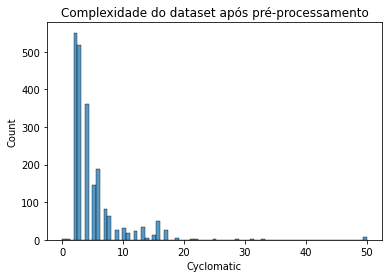

In [315]:
print_dataset_info()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset'}, xlabel='count', ylabel='Project'>

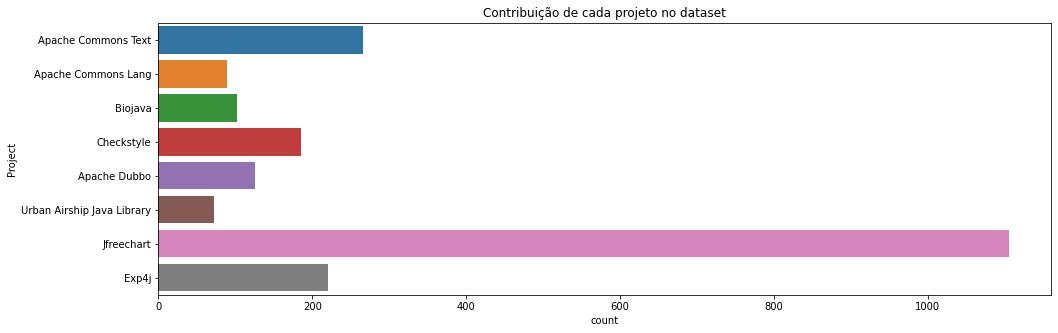

In [316]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
        
    return project

d2 = dataset
d2['Project'] = dataset['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

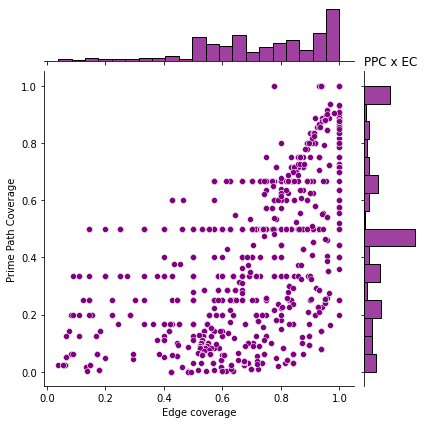

In [317]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.title("PPC x EC")
plt.show(ax)

<AxesSubplot:title={'center':'Correlação das métricas'}>

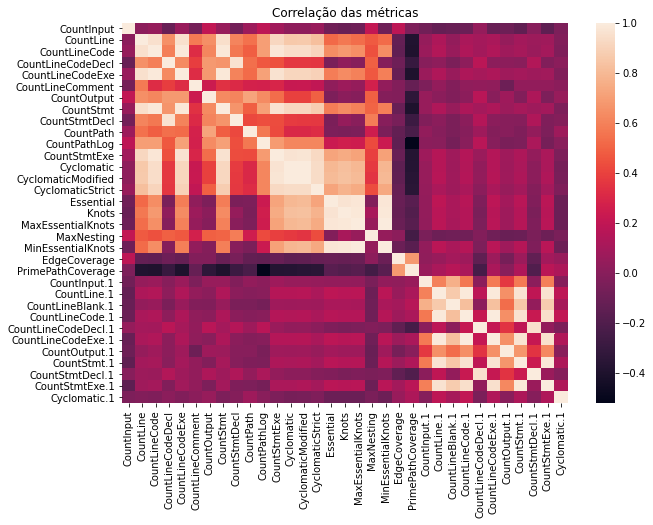

In [318]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas")
sns.heatmap(dataset.corr())

In [320]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166 entries, 1091 to 2424
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 2166 non-null   object 
 1   CountInput           2166 non-null   int64  
 2   CountLine            2166 non-null   int64  
 3   CountLineCode        2166 non-null   int64  
 4   CountLineCodeDecl    2166 non-null   int64  
 5   CountLineCodeExe     2166 non-null   int64  
 6   CountLineComment     2166 non-null   int64  
 7   CountOutput          2166 non-null   int64  
 8   CountStmt            2166 non-null   int64  
 9   CountStmtDecl        2166 non-null   int64  
 10  CountPath            2166 non-null   int64  
 11  CountPathLog         2166 non-null   int64  
 12  CountStmtExe         2166 non-null   int64  
 13  Cyclomatic           2166 non-null   int64  
 14  CyclomaticModified   2166 non-null   int64  
 15  CyclomaticStrict     2166 non-null 

In [321]:
dataset.describe()

,CountInput,CountLine,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountStmt,CountStmtDecl,CountPath,...,CountLine.1,CountLineBlank.1,CountLineCode.1,CountLineCodeDecl.1,CountLineCodeExe.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountStmtExe.1,Cyclomatic.1
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,...,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000
mean,27.818560,28.595106,19.729455,3.259003,13.477378,8.083564,6.576639,13.631117,3.287627,110.865651,...,21.321330,2.311634,16.652816,4.348569,14.011080,7.885503,13.326870,3.915051,9.411819,1.258541
std,47.934654,22.323508,18.206811,4.005752,13.805886,6.355732,5.952498,12.019620,3.670858,806.315450,...,23.449876,5.148629,16.787174,2.788117,16.591794,5.120515,14.415103,2.477834,14.036025,0.868014
min,2.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,3.000000,0.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
25%,5.000000,18.000000,10.000000,1.000000,6.000000,6.000000,3.000000,7.000000,2.000000,2.000000,...,10.000000,0.000000,8.000000,3.000000,6.000000,5.000000,6.000000,2.000000,3.000000,1.000000
50%,9.000000,22.000000,14.500000,2.000000,9.000000,7.000000,5.000000,11.000000,2.000000,4.000000,...,16.000000,1.000000,13.000000,4.000000,10.000000,7.000000,10.000000,3.000000,6.000000,1.000000
75%,23.000000,31.000000,22.000000,3.000000,15.000000,10.000000,8.000000,15.000000,3.000000,6.000000,...,25.000000,3.000000,19.000000,5.000000,16.000000,9.000000,16.000000,5.000000,11.000000,1.000000
max,201.000000,193.000000,171.000000,41.000000,120.000000,98.000000,58.000000,101.000000,42.000000,6912.000000,...,325.000000,52.000000,234.000000,23.000000,232.000000,59.000000,214.000000,19.000000,207.000000,11.000000


# Funções uteis

In [327]:
k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
]

In [335]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=11, apenas_escalonamento=False):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values

    if not apenas_escalonamento:
        resultados = cross_validate(
                classificador, 
                previsores_content, 
                ppc, 
                cv=k, 
                scoring=metricas_erro, 
                return_estimator=True
        )
        
        print('-----< SEM ESCALONAMENTO >-----')
        print('Mean Abs Error: ', abs(resultados['test_neg_mean_absolute_error'].mean()))
        print('Mean Sqr Error: ', abs(resultados['test_neg_mean_squared_error'].mean()))
        print('Mean Sqr Log Error: ', abs(resultados['test_neg_mean_squared_log_error'].mean()))
        print('Mean Median Error: ', abs(resultados['test_neg_median_absolute_error'].mean()))
        print('R2 Score: ', abs(resultados['test_r2'].mean()))
        
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    print('-----< COM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados_escalonados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados_escalonados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados_escalonados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados_escalonados['test_r2'].mean()))

In [329]:
def feature_importance(classificador, d = dataset, prev = previsores):
    ppc = d['PrimePathCoverage'].values
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    previsores_content = d[prev].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    #print(resultados)
    for idx,estimator in enumerate(resultados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances
 
    #print(importance_dataset) 
    importance_dataset['mean'] = importance_dataset['importance'] / k
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()
    
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    print('\n')
    
    print('-----< COM ESCALONAMENTO >-----')
    for idx,estimator in enumerate(resultados_escalonados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances

    importance_dataset['mean'] = importance_dataset['importance'] / k
    #print(importance_dataset)
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()

# Experimentos

## Linear Regression

### Com EC

In [330]:
for previsor in previsores:
    print('PREVISOR ', previsor)
    evaluate([
        previsor
    ], LinearRegression(fit_intercept=False), dataset)
    print('\n')

PREVISOR  CountInput
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.4679057735293991
Mean Sqr Error:  0.30071613027138766
Mean Sqr Log Error:  0.15200465600065535
Mean Median Error:  0.44508166281869666
R2 Score:  4.973794813927909
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.4703104143975718
Mean Sqr Error:  0.302252668448236
Mean Sqr Log Error:  0.1561625016229324
Mean Median Error:  0.43923183592429454
R2 Score:  4.8022597809036665


PREVISOR  CountLine
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.4481704543859877
Mean Sqr Error:  0.3618511003910873
Mean Sqr Log Error:  0.13953497351862243
Mean Median Error:  0.4083521399251015
R2 Score:  4.381158919812773
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.47632026549278517
Mean Sqr Error:  0.4057062152707702
Mean Sqr Log Error:  0.15651716948651942
Mean Median Error:  0.4332405982442342
R2 Score:  5.0587018818338665


PREVISOR  CountLineCode
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.49126840608595823
Mean S

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.5034444298031668
Mean Sqr Error:  0.3687802667791797
Mean Sqr Log Error:  0.18314001186510512
Mean Median Error:  0.45244001008148854
R2 Score:  5.34705980457386
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.5034444298031668
Mean Sqr Error:  0.3687802667791797
Mean Sqr Log Error:  0.18314001186510512
Mean Median Error:  0.4524400100814885
R2 Score:  5.347059804573859


PREVISOR  EdgeCoverage
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.18818931961978136
Mean Sqr Error:  0.05054331782520389
Mean Sqr Log Error:  0.023987671258618417
Mean Median Error:  0.18398331209801794
R2 Score:  0.13987559159753757
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.18691760446167124
Mean Sqr Error:  0.049718114364728595
Mean Sqr Log Error:  0.023682134529482347
Mean Median Error:  0.18536932216079513
R2 Score:  0.15025831980605564


PREVISOR  CountInput.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.4543407811492667
Mean Sqr Error:  

In [331]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.18818931961978136
Mean Sqr Error:  0.05054331782520389
Mean Sqr Log Error:  0.023987671258618417
Mean Median Error:  0.18398331209801794
R2 Score:  0.13987559159753757
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.18691760446167124
Mean Sqr Error:  0.049718114364728595
Mean Sqr Log Error:  0.023682134529482347
Mean Median Error:  0.18536932216079513
R2 Score:  0.15025831980605564


In [333]:
evaluate([
    'MaxNesting'
], LinearRegression(fit_intercept=False), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.3383552848884945
Mean Sqr Error:  0.19780877922662896
Mean Sqr Log Error:  0.08599863235419773
Mean Median Error:  0.2692014402451233
R2 Score:  2.0647409587058885
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.3383552848884944
Mean Sqr Error:  0.19780877922662896
Mean Sqr Log Error:  0.08599863235419772
Mean Median Error:  0.2692014402451233
R2 Score:  2.064740958705889


### Sem EC

## SVR

### Com EC

In [336]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], SVR(epsilon=0.2), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.13399634009673614
Mean Sqr Error:  0.025785761412714728
Mean Sqr Log Error:  0.01277640556773166
Mean Median Error:  0.12574402981923696
R2 Score:  0.5473574953389662


In [344]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], SVR(epsilon=0.4), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.17728669025298252
Mean Sqr Error:  0.04548632489420587
Mean Sqr Log Error:  0.021056335979712907
Mean Median Error:  0.15411213803158477
R2 Score:  0.2392235311864031


In [338]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], SVR(), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.20510149741674233
Mean Sqr Error:  0.06530140612157344
Mean Sqr Log Error:  0.027731868490394808
Mean Median Error:  0.1705417757001743
R2 Score:  0.08680058128281315


In [341]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], SVR(epsilon=0.2), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.19861122633851067
Mean Sqr Error:  0.055366851988903204
Mean Sqr Log Error:  0.024485384040313276
Mean Median Error:  0.1821400334267426
R2 Score:  0.06883046360310317


In [343]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], SVR(epsilon=0.4), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.17404982857824475
Mean Sqr Error:  0.0449135636514218
Mean Sqr Log Error:  0.020787059172938886
Mean Median Error:  0.14378732353485874
R2 Score:  0.2644299544060184


### Sem EC

## Neural network

### Com EC

In [345]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\skl

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [346]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(
        hidden_layer_sizes=(122,), 
        activation='tanh', 
        learning_rate='invscaling', 
        alpha=0.1,
        random_state=0
), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [347]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], MLPRegressor(), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [348]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [349]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

### Sem EC

## Random forest

### Com EC

-----< SEM ESCALONAMENTO >-----


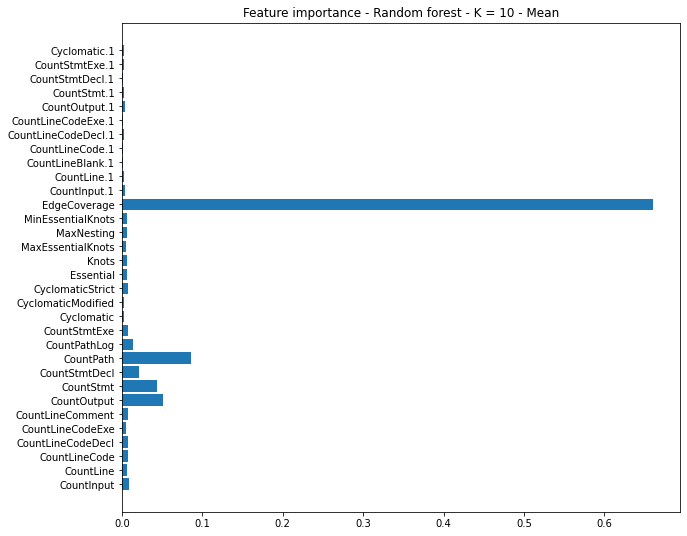



-----< COM ESCALONAMENTO >-----


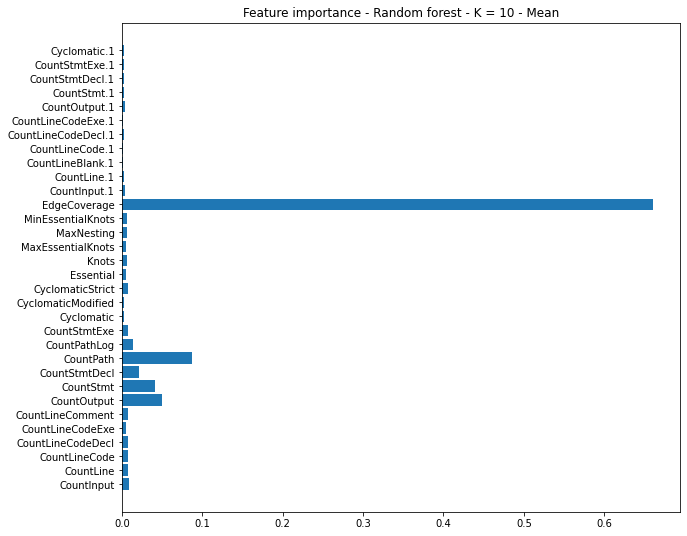

In [351]:
feature_importance(RandomForestRegressor())

In [352]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'CountPath',
    'CountStmt'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.08397032706744033
Mean Sqr Error:  0.019465950028317622
Mean Sqr Log Error:  0.009001089914241657
Mean Median Error:  0.051160598484848524
R2 Score:  0.6786790332860811
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.0841474583096792
Mean Sqr Error:  0.019637452174152897
Mean Sqr Log Error:  0.009086364928823544
Mean Median Error:  0.05008053679653682
R2 Score:  0.6796328681179792


In [353]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.09514854167414642
Mean Sqr Error:  0.024502002555524125
Mean Sqr Log Error:  0.012326249644595982
Mean Median Error:  0.0517385122185322
R2 Score:  0.5929726974350228
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.09526935216701911
Mean Sqr Error:  0.02459562321171911
Mean Sqr Log Error:  0.012421047367055599
Mean Median Error:  0.05505197735690238
R2 Score:  0.5923987742556961


In [354]:
evaluate([
    'CountOutput',
    'CountPath',
    'CountStmt'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.21256775820943144
Mean Sqr Error:  0.07304588839718176
Mean Sqr Log Error:  0.031629610683920444
Mean Median Error:  0.1865487925059586
R2 Score:  0.24503488713276855
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.2120017108156281
Mean Sqr Error:  0.07240142162559626
Mean Sqr Log Error:  0.0313177035369033
Mean Median Error:  0.18725232696102212
R2 Score:  0.23737884261893624


In [ ]:
evaluate([
    'CountOutput',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], RandomForestRegressor(), dataset)

### Sem EC

-----< SEM ESCALONAMENTO >-----


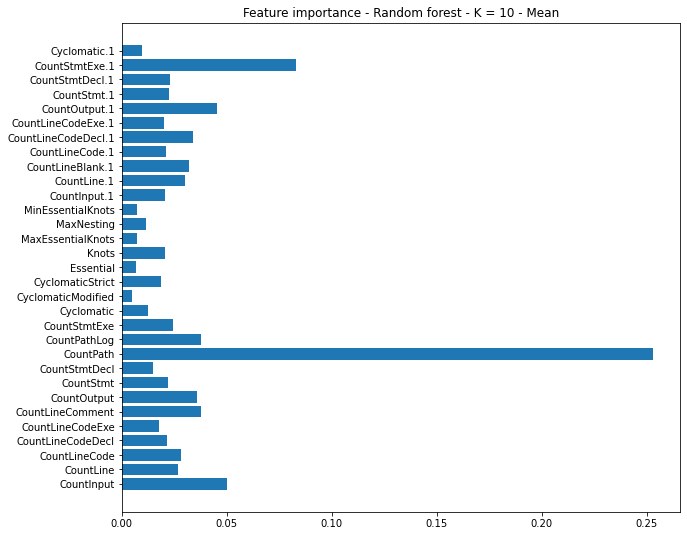



-----< COM ESCALONAMENTO >-----


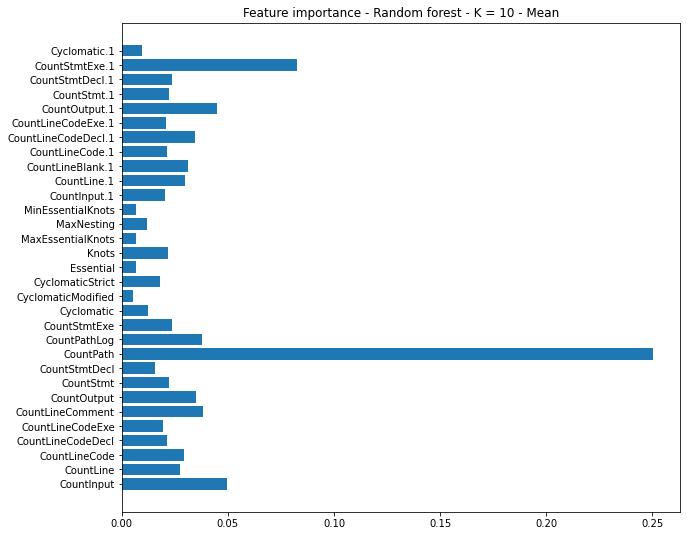

In [355]:
feature_importance(RandomForestRegressor(), prev=[
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
])

In [356]:
evaluate([
    'CountStmtExe.1',
    'MaxNesting',
    'CountPath',
    'CountOutput.1',
    'CountLineCodeExe.1'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.18795805939016466
Mean Sqr Error:  0.05770244968852119
Mean Sqr Log Error:  0.02469965172323281
Mean Median Error:  0.15320695981240978
R2 Score:  0.007807483834682933
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.18656365322186536
Mean Sqr Error:  0.05709463525907039
Mean Sqr Log Error:  0.02443678802143451
Mean Median Error:  0.152271188814038
R2 Score:  0.019209343179986894


In [357]:
evaluate([
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.1931264990113186
Mean Sqr Error:  0.05564307262742146
Mean Sqr Log Error:  0.023996642741583665
Mean Median Error:  0.18173897575757578
R2 Score:  0.09768059836513862
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.19484822966338927
Mean Sqr Error:  0.056801889675387414
Mean Sqr Log Error:  0.024437460130903418
Mean Median Error:  0.184733006060606
R2 Score:  0.07712633094790734


In [358]:
evaluate([
    'CountStmtExe.1',
    'MaxNesting',
    'CountPath',
    'CountOutput.1',
    'CountLineCodeExe.1',
    'Cyclomatic',
    'CountInput',
    'CountOutput',
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.18973836995146715
Mean Sqr Error:  0.05630748658341266
Mean Sqr Log Error:  0.024114432327358538
Mean Median Error:  0.17287995021645014
R2 Score:  0.08235012395875073
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.19165460512742555
Mean Sqr Error:  0.05714479287610097
Mean Sqr Log Error:  0.024436542857948638
Mean Median Error:  0.17785394329004323
R2 Score:  0.06840034137726098
